In [91]:
from lxml import etree as ET
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from cycler import cycler
import matplotlib.ticker as ticker
from os.path import join

# Constants and reusable functions

In [92]:
N_VECTORS = 1e6
ONE_MB = 2 ** 20
FLOAT_SIZE_B = 4
VECTOR_DIM = 128
VECTOR_SIZE = VECTOR_DIM * FLOAT_SIZE_B
VECTOR_SIZE_MB = VECTOR_SIZE / ONE_MB
N_QUERY_VECTORS = 1e4
NS_PER_S = 1e9
S_PER_MIN = 60
MS_PER_S = 1e3

Reusable functions for parsing and preprocessing

In [93]:
# read benchmark parameters like `n_lists` and `n_probe` which are stored in a `Warning` tag (key := value) preceding the `BenchmarkResults` tag
def extract_benchmark_params(element):
    params = {}
    for sibling in element.itersiblings(preceding=True):
        if sibling.tag == 'Warning':
            parts = list(map(lambda s: s.strip(), sibling.text.split(':=')))
            params[parts[0]] = parts[1]
    return params

def parse_xml(filename):
    filepath = os.path.join('performance', filename)
    tree = ET.parse(filepath)
    root = tree.getroot()
    results = []
    for match in root.iter('BenchmarkResults'):
        result = extract_benchmark_params(match)
        result['mean'] = match.find('mean').get('value')
        result['std'] = match.find('standardDeviation').get('value')
        results.append(result)
    return results

def parse_xml_recall(filename):
    filepath = os.path.join('recall', filename)
    tree = ET.parse(filepath)
    root = tree.getroot()
    results = []
    for match in root.iter('Warning'):
        if not match.text.strip().startswith('Recall'):
            continue
        result = extract_benchmark_params(match)
        result['recall@1'] = match.text.split(':=')[1].strip()
        results.append(result)
    return results

In [94]:
def results_to_df(results):
    df = pd.DataFrame(results)
    # convert mean and std from nanoseconds to seconds, we divide by 10^9
    # since the benchmark runs for 10^4 query vectors, we divide by another 10^4

    columns = []

    if 'max_n_threads' in df.columns:
        df['max_n_threads'] = df['max_n_threads'].astype(int)
        columns += ['max_n_threads']

    if 'n_lists' in df.columns:
        df['n_lists'] = df['n_lists'].astype(int)
        columns += ['n_lists']

    if 'n_probe' in df.columns:
        df['n_probe'] = df['n_probe'].astype(int)
        columns += ['n_probe']

    if 'n_results' in df.columns:
        df['n_results'] = df['n_results'].astype(int)
        columns += ['n_results']
        
    if 'mean' in df.columns:
        df['mean'] = df['mean'].astype(float)
        df['mean'] = df['mean'] / NS_PER_S / N_QUERY_VECTORS
        columns += ['mean']

    if 'std' in df.columns:
        df['std'] = df['std'].astype(float)
        df['std'] = df['std'] / NS_PER_S / N_QUERY_VECTORS
        columns += ['std']
    
    if 'recall@1' in df.columns:
        df['recall@1'] = df['recall@1'].astype(float)
        columns += ['recall@1']

    return df[columns]

Search space size for the vector search and search_preassigned
- Since we normalized the measurements by dividing by the number of query vectors, here we consider the search space size and the size of the candidates for a single query vector as well.
- Since we're searching through the SIFT1M dataset with $10^6$ vectors, we can compute the number of vectors per list `n_vectors_per_list` given the number of lists `n_lists`:
$$
\text{n\_vectors\_per\_list} = \frac{10^6}{\text{n\_lists}}
$$.
- We find the total number of vectors which need to be searched as the product of `n_vectors_per_list` and `n_probe`, therefore:

$$
\text{n\_vectors\_to\_search} = \text{n\_vectors\_per\_list} * \text{n\_probe} = \frac{10^6}{\text{n\_lists}} * \text{n\_probe}
$$.

- Assuming $128$-dimensional vectors of floats, we can estimate the size of the search space in MB as:
$$
\text{vector\_size\_mb} = \frac{128 * 4}{2^{20}}
$$
$$
\text{search\_space\_size\_mb} = \text{n\_vectors\_to\_search} * \text{vector\_size\_mb}
$$.

- For `preassign_query`, the search space is only proportional to the number of lists since we only need to compare against one centroid per list. Therefore, we can compute the search space size as:
$$
\text{centroids\_total\_size\_mb} = \text{n\_lists} * \text{vector\_size\_mb}
$$.

In [95]:
def add_space_estimates(df):
  df['n_vectors_to_search'] = N_VECTORS / df['n_lists'] * df['n_probe']
  df['search_space_size_mb'] = (df['n_vectors_to_search'] * VECTOR_SIZE_MB).round(1)
  df['centroids_total_size_mb'] = (df['n_lists'] * VECTOR_SIZE_MB).round(1)

Plotting

In [123]:
def plot(df, y_col, ylabel, title, yerr_col=None, legend_loc='best', yformatter=ticker.ScalarFormatter(), yaxis_log=False, plot='n_probe'):
    if plot == 'n_probe':
        x_col = 'n_probe'
        series_col = 'n_lists'
        x_label = 'Number of probes'
        legend_title = 'Number of lists'
    elif plot == 'n_lists':
        x_col = 'n_lists'
        series_col = 'n_probe'
        x_label = 'Number of lists'
        legend_title = 'Number of probes'
    elif plot == 'max_n_threads':
        x_col = 'max_n_threads'
        series_col = 'n_probe'
        x_label = 'Max number of threads'
        legend_title = 'Number of probes'
    elif plot == 'n_results':
        x_col = 'n_results'
        series_col = 'n_probe'
        x_label = 'Number of results'
        legend_title = 'Number of probes'
    elif plot == 'n_results':
        x_col = 'n_results'
        series_col = 'n_probe'
        x_label = 'Number of results'
        legend_title = 'Number of probes'
    else:
        raise ValueError(f'Invalid value for plot: {plot}')
    fig, ax = plt.subplots(tight_layout=True)
    ax.set_prop_cycle(marker_cycler)
    ax.set_title(title)
    for n_lists in reversed(sorted(df[series_col].unique())):
        params = {'markersize': 7, 'lw': 2, 'label': f'{n_lists}'}
        df_subset = df[df[series_col] == n_lists]
        if yerr_col:
            params = {**params, 'capsize': 7, 'capthick': 1}
            ax.errorbar(x=df_subset[x_col], y=df_subset[y_col], yerr=df_subset[yerr_col], **params)
        else:    
            ax.plot(df_subset[x_col], df_subset[y_col], **params)

    ax.set_xlabel(x_label)
    ax.set_xscale('log')
    ax.xaxis.set_major_locator(ticker.LogLocator(base=2))
    ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
    ax.xaxis.set_minor_locator(ticker.NullLocator())

    if yaxis_log:
        ax.set_yscale('log')
    ax.set_ylabel(ylabel)
    ax.yaxis.set_major_formatter(yformatter)

    ax.legend(title=legend_title, loc=legend_loc)
    plt.show()

marker_cycler = cycler(color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
                         '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
                         '#bcbd22', '#17becf'], marker=['o', 's', '^', 'd', '*', '+', 'x', 'v', 'p', 'h'])

s_to_ms_formatter = ticker.FuncFormatter(lambda x, pos: '{:0.1f}'.format(x*1000))
s_to_us_formatter = ticker.FuncFormatter(lambda x, pos: '{:0.1f}'.format(x*1e6))
mb_to_gb_formatter = ticker.FuncFormatter(lambda x, pos: '{:0.1f}'.format(x/2**10))
speedup_formatter = ticker.FuncFormatter(lambda x, pos: '{:0.1f}'.format(x))


Throughput

In [97]:
def get_vector_throughput(df, n_vectors_column, seconds_column):
    vectors_per_s = (df[n_vectors_column] / df[seconds_column]).round(1)
    mb_per_s = (vectors_per_s * VECTOR_SIZE / ONE_MB).round(1)
    return vectors_per_s, mb_per_s

def add_centroids_search_throughput(centroids_df):
    centroids_df['vectors_per_s'], centroids_df['mb_per_s'] = get_vector_throughput(centroids_df, 'n_lists', 'mean')
    return centroids_df

def add_search_throughput(search_df):
  search_df['n_vectors_per_s'], search_df['mb_per_s'] = get_vector_throughput(search_df, 'n_vectors_to_search', 'mean')
  return search_df

Speedup

In [98]:
def get_speedup(old_df, new_df, column, invert=False):
  speedup = new_df[column] / old_df[column]
  if invert:
    speedup = 1 / speedup
  return speedup.round(1)

# `bulk_insert_entries`

**Sorted vs Unsorted**

In [162]:
unsorted = [{'n_lists': 512, 'n_probe': 1, 'mean': 2.02024e+09, 'std': 4.9847e+06}, {'n_lists': 1024, 'n_probe': 1, 'mean': 5.54063e10, 'std': 1.41458e09}]
unsorted_df = results_to_df(unsorted)
unsorted_df

,n_lists,n_probe,mean,std
0,512,1,0.000202,4.984700e-07
1,1024,1,0.005541,1.414580e-04


In [163]:
sorted = [{'n_lists': 512, 'n_probe': 1, 'mean': 2.84686e+09, 'std': 1.1119e+07},{'n_lists': 1024, 'n_probe': 1, 'mean': 3.68418e+09, 'std': 7.2396e07}]
sorted_df = results_to_df(sorted)
sorted_df['mean_speedup'] = get_speedup(old_df=unsorted_df, new_df=sorted_df, column='mean', invert=True)
sorted_df

,n_lists,n_probe,mean,std,mean_speedup
0,512,1,0.000285,0.000001,0.7
1,1024,1,0.000368,0.000007,15.0


# No SIMD, No OpenMP

## `preassign_query()`

Parsing measurements from xml output of testing framework

In [99]:
!head -n 10 preassign_query.xml

<?xml version="1.0" encoding="UTF-8"?>
<Catch name="testmain" filters="[StorageIndex][preassign_query][benchmark][SIFT1M]">
  <Group name="testmain">
    <TestCase name="Scenario: preassign_query()"
      tags="[SIFT1M][StorageIndex][benchmark][preassign_query]" filename="tests/IndexTest.cpp"
      line="327">
      <Section name="Then: all required files are present" filename="tests/IndexTest.cpp" line="112">
        <Section name="When: the files are mapped to memory" filename="tests/IndexTest.cpp"
          line="121">
          <Section name="Then: the files are mapped correctly" filename="tests/IndexTest.cpp"


In [100]:

centroids_df = results_to_df(parse_xml('preassign_query.xml'))
add_space_estimates(centroids_df)
add_centroids_search_throughput(centroids_df)
centroids_df

,n_lists,n_probe,mean,std,n_vectors_to_search,search_space_size_mb,centroids_total_size_mb,vectors_per_s,mb_per_s
0,256,1,0.000137,7.241680e-06,3906.250000,1.9,0.1,1870278.6,913.2
1,256,2,0.000135,1.982430e-07,7812.500000,3.8,0.1,1900646.7,928.1
2,256,4,0.000139,2.378660e-07,15625.000000,7.6,0.1,1835770.3,896.4
3,256,8,0.000148,2.265780e-07,31250.000000,15.3,0.1,1731531.5,845.5
4,256,16,0.000163,2.517420e-07,62500.000000,30.5,0.1,1573380.4,768.3
5,256,32,0.000191,2.407650e-07,125000.000000,61.0,0.1,1341838.6,655.2
6,256,64,0.000230,2.071410e-07,250000.000000,122.1,0.1,1110701.3,542.3
7,256,128,0.000280,3.106660e-07,500000.000000,244.1,0.1,912877.3,445.7
8,512,1,0.000262,8.995370e-08,1953.125000,1.0,0.2,1955713.8,954.9
9,512,2,0.000265,2.552420e-07,3906.250000,1.9,0.2,1933622.4,944.2


**Search Space Size**

Here, we see how the search space behaves as we increase the number of lists and probes.
- The search space for the search_preassigned, i.e. `preassign_query`, grows linearly but only in proportion to the number of lists.


In [101]:
centroids_mean_by_n_lists_df = centroids_df.groupby('n_lists').mean()
centroids_std_by_n_lists_df = centroids_df.groupby('n_lists').std()
centroids_mean_by_n_lists_df

,n_probe,mean,std,n_vectors_to_search,search_space_size_mb,centroids_total_size_mb,vectors_per_s,mb_per_s
n_lists,,,,,,,,
256,31.875,0.000178,1.114335e-06,124511.718750,60.7875,0.1,1.534628e+06,749.3375
512,31.875,0.000322,2.845366e-07,62255.859375,30.4000,0.2,1.655195e+06,808.2000
1024,31.875,0.000597,7.747084e-07,31127.929688,15.2000,0.5,1.750951e+06,854.9500
2048,31.875,0.001133,2.137319e-07,15563.964844,7.6000,1.0,1.824640e+06,890.9500
4096,31.875,0.002186,2.974162e-07,7781.982422,3.8000,2.0,1.880466e+06,918.2125


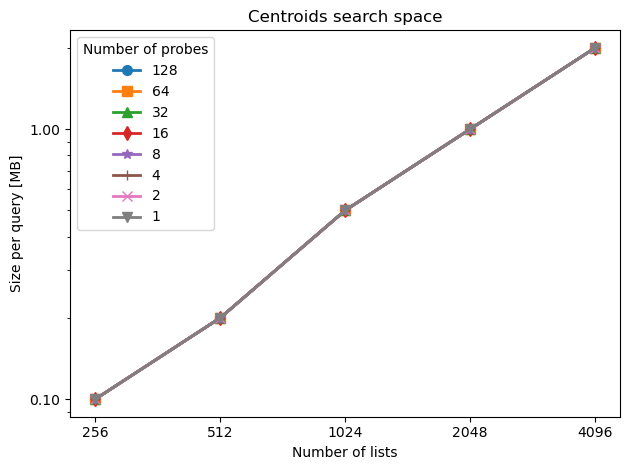

In [102]:
plot(centroids_df, 'centroids_total_size_mb', 'Size per query [MB]', 'search_preassigned space', plot='n_lists', yaxis_log=True)

In [103]:
centroids_mean_by_n_probe_df = centroids_df.groupby('n_probe').mean()
centroids_std_by_n_probe_df = centroids_df.groupby('n_probe').std()
centroids_mean_by_n_probe_df

,n_lists,mean,std,n_vectors_to_search,search_space_size_mb,centroids_total_size_mb,vectors_per_s,mb_per_s
n_probe,,,,,,,,
1,1587.2,0.000808,1.898404e-06,1513.671875,0.74,0.76,1944973.62,949.70
2,1587.2,0.000810,3.234488e-07,3027.343750,1.48,0.76,1941957.20,948.24
4,1587.2,0.000817,2.284020e-07,6054.687500,2.96,0.76,1912809.12,934.00
8,1587.2,0.000829,1.892073e-07,12109.375000,5.92,0.76,1863559.12,909.96
16,1587.2,0.000851,3.871588e-07,24218.750000,11.82,0.76,1779554.54,868.94
32,1587.2,0.000893,1.903955e-07,48437.500000,23.64,0.76,1645246.36,803.34
64,1587.2,0.000968,4.229257e-07,96875.000000,47.30,0.76,1472549.74,719.00
128,1587.2,0.001091,6.556228e-07,193750.000000,94.60,0.76,1272758.80,621.46


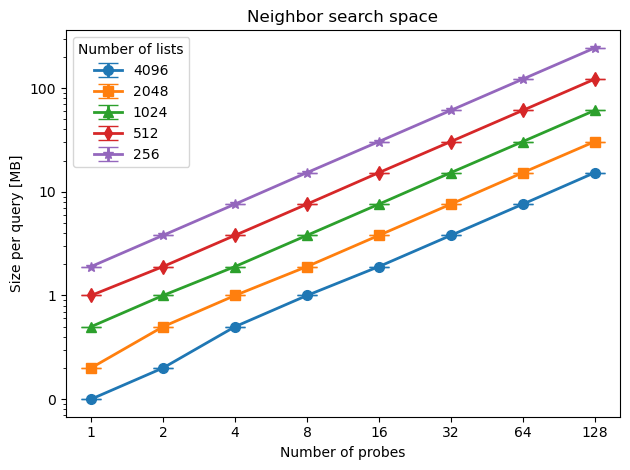

In [104]:
plot(centroids_df, 'search_space_size_mb', 'Size per query [MB]', 'preassign_query space', yerr_col='std', yaxis_log=True)

**Execution Time**
- As we can see in the below loglog plot, `preassign_query` scales linearly with the number of lists.

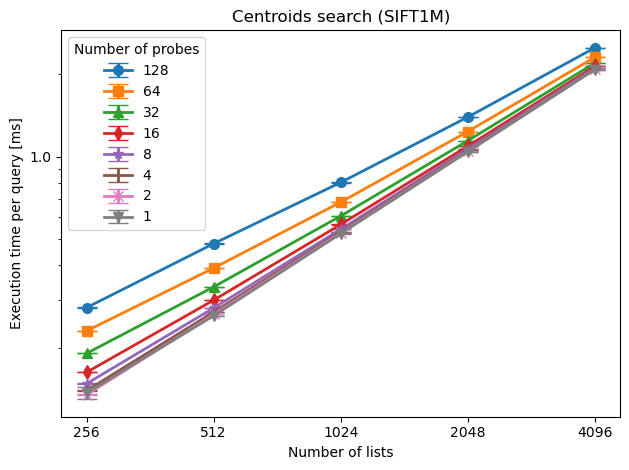

In [105]:
plot(df=centroids_df, y_col='mean', yerr_col='std', ylabel='Execution time per query [ms]', title='search_preassigned (SIFT1M)', legend_loc='upper left', plot='n_lists', yaxis_log=True, yformatter=s_to_ms_formatter)

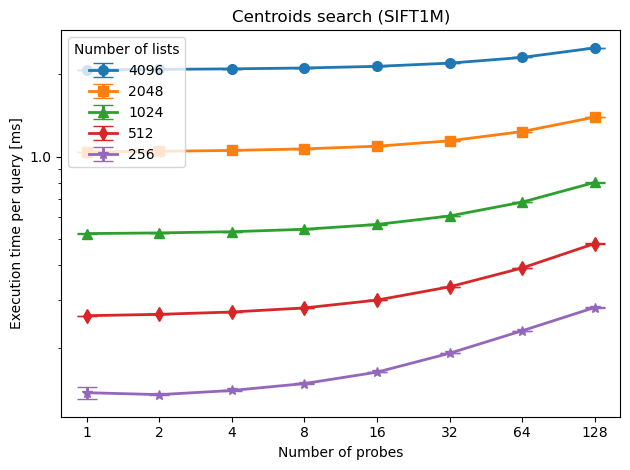

In [106]:
plot(df=centroids_df, y_col='mean', yerr_col='std', ylabel='Execution time per query [ms]', title='search_preassigned (SIFT1M)', legend_loc='upper left', yaxis_log=True, yformatter=s_to_ms_formatter)

**Throughput**

- Search space = number of centroids to compare against = `n_lists`
- Candidates = number of closest centroids to find = `n_probe`
- For a fixed `n_lists` and increasing `n_probe`, we expect the throughput to decrease since we need to compare against the current list of `n_probe` candidates (using a heap) while searching through the constant search space which is fixed with the number of lists.

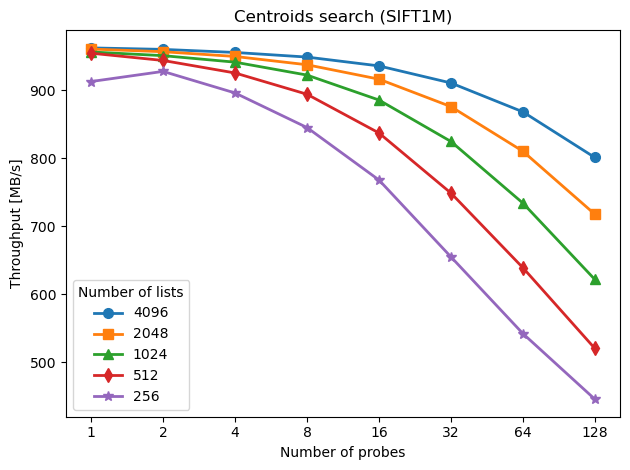

In [107]:
plot(df=centroids_df, y_col='mb_per_s', ylabel='Throughput [MB/s]', title='search_preassigned (SIFT1M)')

## `search_preassigned`

In [108]:
!head -n 10 search_preassigned.xml

<?xml version="1.0" encoding="UTF-8"?>
<Catch name="testmain" filters="[StorageIndex][search_preassigned][benchmark][SIFT1M]">
  <Group name="testmain">
    <TestCase name="Scenario: search_preassigned(): benchmark querying with SIFT1M" tags="[SIFT1M][StorageIndex][benchmark][search_preassigned]" filename="tests/IndexTest.cpp" line="263">
      <Section name="Then: all required files are present" filename="tests/IndexTest.cpp" line="112">
        <Section name="When: the files are mapped to memory" filename="tests/IndexTest.cpp" line="121">
          <Section name="Then: the files are mapped correctly" filename="tests/IndexTest.cpp" line="141">
            <OverallResults successes="5" failures="0" expectedFailures="0"/>
          </Section>
          <OverallResults successes="5" failures="0" expectedFailures="0"/>


In [109]:
!tail -n 15 search_preassigned.xml

            </Section>
            <OverallResults successes="0" failures="0" expectedFailures="0"/>
          </Section>
          <OverallResults successes="0" failures="0" expectedFailures="0"/>
        </Section>
        <OverallResults successes="6" failures="0" expectedFailures="0"/>
      </Section>
      <OverallResult success="true"/>
    </TestCase>
    <OverallResults successes="680" failures="0" expectedFailures="0"/>
    <OverallResultsCases successes="1" failures="0" expectedFailures="0"/>
  </Group>
  <OverallResults successes="680" failures="0" expectedFailures="0"/>
  <OverallResultsCases successes="1" failures="0" expectedFailures="0"/>
</Catch>


Here, we convert the results array to a pandas dataframe for easier plotting.

In [110]:
search_df = results_to_df(parse_xml('search_preassigned.xml'))
add_space_estimates(search_df)
add_search_throughput(search_df)
search_df

,n_lists,n_probe,mean,std,n_vectors_to_search,search_space_size_mb,centroids_total_size_mb,n_vectors_per_s,mb_per_s
0,256,1,0.002165,1.801050e-05,3906.250000,1.9,0.1,1804572.6,881.1
1,256,2,0.004224,4.555090e-06,7812.500000,3.8,0.1,1849532.7,903.1
2,256,4,0.008316,1.418760e-06,15625.000000,7.6,0.1,1878872.0,917.4
3,256,8,0.016347,3.687860e-08,31250.000000,15.3,0.1,1911689.1,933.4
4,256,16,0.032127,2.422630e-06,62500.000000,30.5,0.1,1945416.3,949.9
5,256,32,0.063205,1.697430e-06,125000.000000,61.0,0.1,1977685.4,965.7
6,256,64,0.124587,2.492890e-05,250000.000000,122.1,0.1,2006629.9,979.8
7,256,128,0.247795,7.187450e-06,500000.000000,244.1,0.1,2017797.0,985.3
8,512,1,0.001096,2.195580e-06,1953.125000,1.0,0.2,1782633.9,870.4
9,512,2,0.002164,6.334090e-06,3906.250000,1.9,0.2,1805481.7,881.6


**Execution Time**

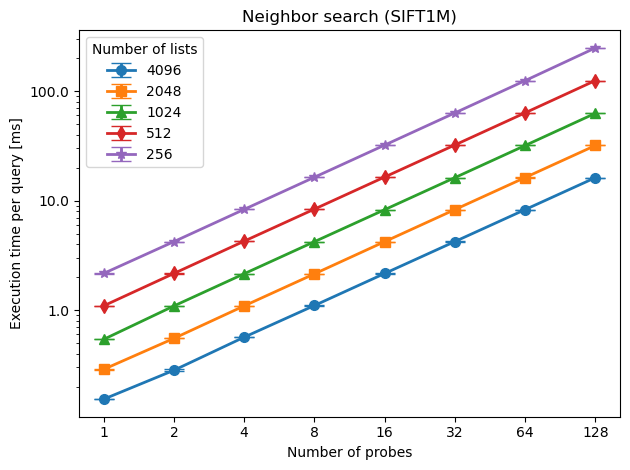

In [111]:
plot(df=search_df, y_col='mean', yerr_col='std', title='preassign_query (SIFT1M)', ylabel='Execution time per query [ms]', yaxis_log=True, yformatter=s_to_ms_formatter)

**Throughput**
- Search space ~ 1 / number of lists * number of vectors per list = 1 / `n_lists` * `n_vectors_per_list`
- For a fixed `n_lists` and increasing `n_probe`, the throughput increases since we increase the search space size which reduces the relative overhead of the search.
- For a fixed `n_probe` and increasing `n_lists`, the throughput decreases since the length of the individual lists is smaller which reduces the search space size and could lead to more overhead.


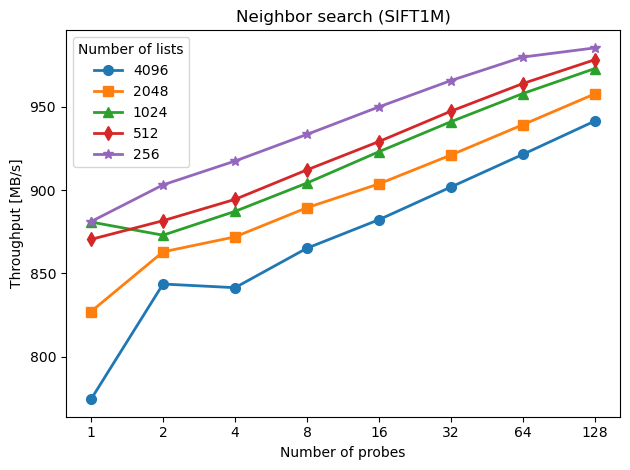

In [112]:
plot(df=search_df, y_col='mb_per_s', title='preassign_query (SIFT1M)', ylabel='Throughput [MB/s]')

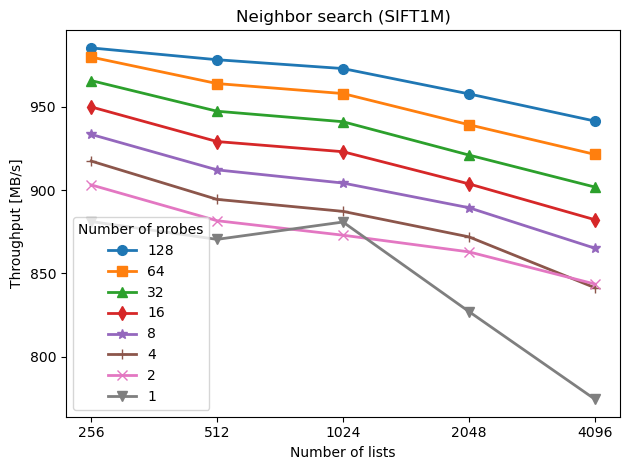

In [113]:
yformatter = ticker.FuncFormatter(lambda x, pos: '{:0.0f}'.format(x*1000))
plot(df=search_df, y_col='mb_per_s', title='preassign_query (SIFT1M)', ylabel='Throughput [MB/s]', plot='n_lists')

# SIMD, no OpenMP

## `preassign_query()`

Executing the benchmark by running the following command:
```bash
./out/testmain [StorageIndex][preassign_query][benchmark] --benchmark-samples 3 -r xml >> preassign_query_simd.xml
```
produces an xml file containing the measurements of the execution time of `preassign_query` for different values of `n_probe` and `n_lists`.




Reading the measurements from the xml file

In [114]:
centroids_simd_df = results_to_df(parse_xml('preassign_query_simd.xml'))
add_space_estimates(centroids_simd_df)
add_centroids_search_throughput(centroids_simd_df)
centroids_simd_df['mean_speedup'] = get_speedup(old_df=centroids_df, new_df=centroids_simd_df, column='mean', invert=True)
centroids_simd_df

,n_lists,n_probe,mean,std,n_vectors_to_search,search_space_size_mb,centroids_total_size_mb,vectors_per_s,mb_per_s,mean_speedup
0,256,1,0.000055,6.876400e-07,3906.250000,1.9,0.1,4639496.6,2265.4,2.5
1,256,2,0.000057,4.075340e-07,7812.500000,3.8,0.1,4506502.7,2200.4,2.4
2,256,4,0.000062,2.269050e-07,15625.000000,7.6,0.1,4153329.2,2028.0,2.3
3,256,8,0.000070,4.254090e-08,31250.000000,15.3,0.1,3659725.6,1787.0,2.1
4,256,16,0.000085,1.838190e-07,62500.000000,30.5,0.1,3006632.2,1468.1,1.9
5,256,32,0.000113,3.355810e-07,125000.000000,61.0,0.1,2259607.7,1103.3,1.7
6,256,64,0.000153,1.890540e-07,250000.000000,122.1,0.1,1674231.2,817.5,1.5
7,256,128,0.000206,2.122310e-07,500000.000000,244.1,0.1,1244579.3,607.7,1.4
8,512,1,0.000109,1.293140e-06,1953.125000,1.0,0.2,4688859.4,2289.5,2.4
9,512,2,0.000111,2.528440e-07,3906.250000,1.9,0.2,4626032.3,2258.8,2.4


**Throughput**

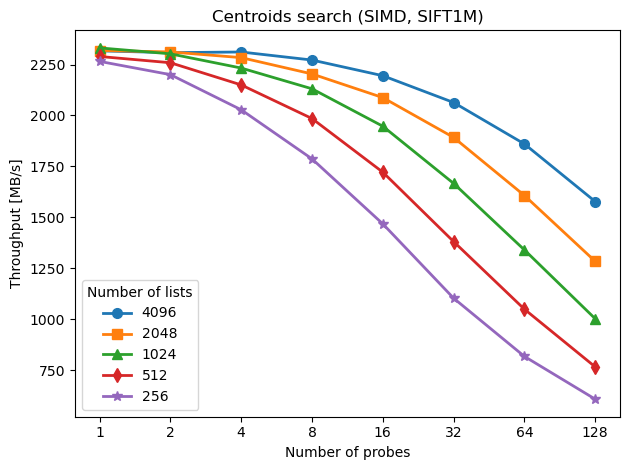

In [115]:
plot(df=centroids_simd_df, y_col='mb_per_s', title='search_preassigned (SIMD, SIFT1M)', ylabel='Throughput [MB/s]')

**Speedup**

Average SIMD speed-up for preassign_query(): 2.1x


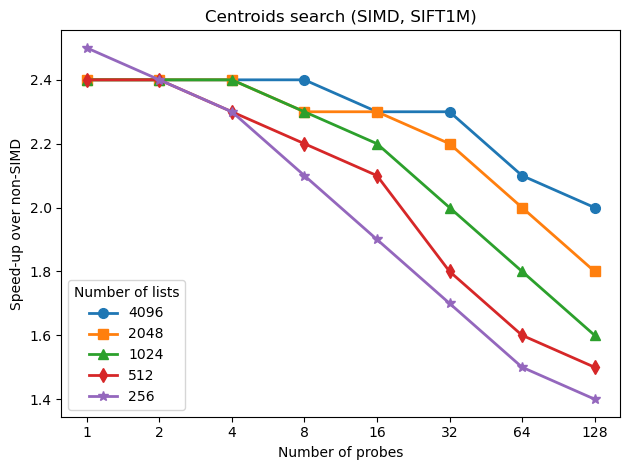

In [116]:
speedup = centroids_simd_df['mean_speedup'].mean()
print(f'Average SIMD speed-up for preassign_query(): {speedup:.1f}x')
plot(df=centroids_simd_df, y_col='mean_speedup', title='search_preassigned (SIMD, SIFT1M)', ylabel='Speed-up over non-SIMD')

## `search_preassigned()`

Executing the benchmark with the following command:

```bash
./out/testmain [StorageIndex][search_preassigned][benchmark] --benchmark-samples 3 -r xml >> search_preassigned_simd.xml
```

produces an xml file containing the measurements of the execution time of `search_preassigned` for different values of `n_probe` and `n_lists`.

Reading the measurements from the xml file

In [117]:
results_search_simd = parse_xml('search_preassigned_simd.xml')
search_simd_df = results_to_df(results_search_simd)
add_space_estimates(search_simd_df)
add_search_throughput(search_simd_df)
search_simd_df['mean_speedup'] = get_speedup(old_df=search_df, new_df=search_simd_df, column='mean', invert=True)
search_simd_df

,n_lists,n_probe,mean,std,n_vectors_to_search,search_space_size_mb,centroids_total_size_mb,n_vectors_per_s,mb_per_s,mean_speedup
0,256,1,0.000899,4.752760e-06,3906.250000,1.9,0.1,4343810.7,2121.0,2.4
1,256,2,0.001774,1.692240e-05,7812.500000,3.8,0.1,4404609.5,2150.7,2.4
2,256,4,0.003481,3.477550e-06,15625.000000,7.6,0.1,4488743.0,2191.8,2.4
3,256,8,0.006835,3.091570e-06,31250.000000,15.3,0.1,4571834.9,2232.3,2.4
4,256,16,0.013435,7.501770e-07,62500.000000,30.5,0.1,4651959.0,2271.5,2.4
5,256,32,0.026427,9.813600e-07,125000.000000,61.0,0.1,4729993.1,2309.6,2.4
6,256,64,0.052095,3.535120e-06,250000.000000,122.1,0.1,4798925.0,2343.2,2.4
7,256,128,0.103600,7.179630e-06,500000.000000,244.1,0.1,4826254.8,2356.6,2.4
8,512,1,0.000467,8.083990e-06,1953.125000,1.0,0.2,4185139.3,2043.5,2.3
9,512,2,0.000908,7.785870e-06,3906.250000,1.9,0.2,4300867.5,2100.0,2.4


**Execution Time**

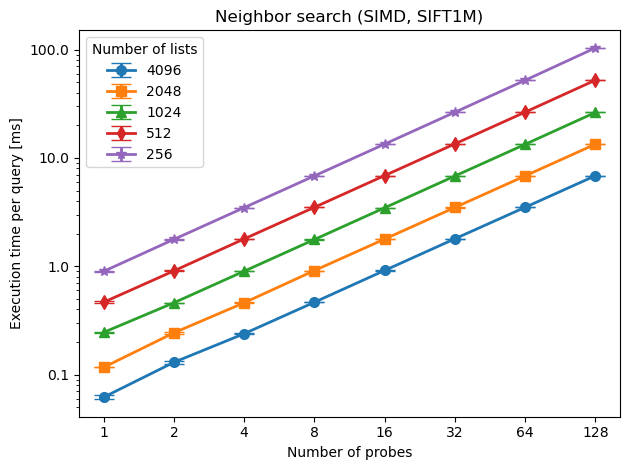

In [118]:
plot(df=search_simd_df, y_col='mean', yerr_col='std', title='preassign_query (SIMD, SIFT1M)', ylabel='Execution time per query [ms]', yaxis_log=True, yformatter=s_to_ms_formatter)

**Throughput**

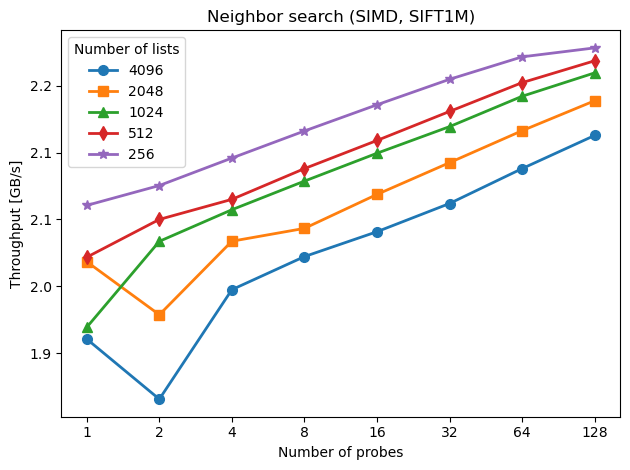

In [127]:
plot(df=search_simd_df, y_col='mb_per_s', title='preassign_query (SIMD, SIFT1M)', ylabel='Throughput [GB/s]', yformatter=mb_to_gb_formatter)

**Speedup**

Average SIMD speed-up for search_preassigned(): 2.4x


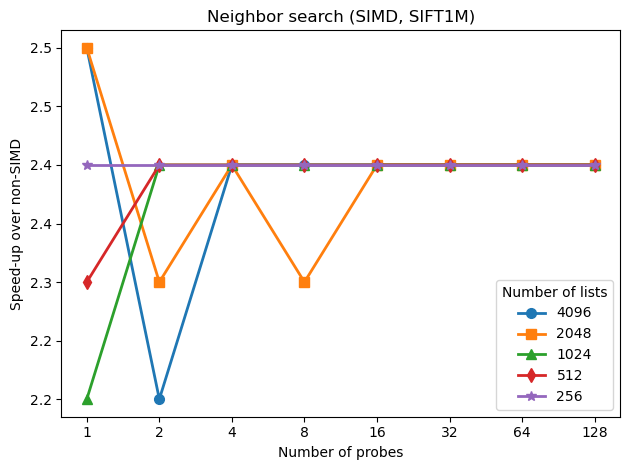

In [128]:
speedup = search_simd_df['mean_speedup'].mean()
print(f'Average SIMD speed-up for search_preassigned(): {speedup:.1f}x')
plot(df=search_simd_df, y_col='mean_speedup', title='preassign_query (SIMD, SIFT1M)', ylabel='Speed-up over non-SIMD', yformatter=speedup_formatter)

# SIMD, OpenMP (over queries)

- The following benchmarks were executed on a `Intel Xeon E5-2640 @ 2.4 GHz` with 32 cores, each with 2 threads.
- OpenMP was configured to use up to `64` threads by configuring `OMP_NUM_THREADS`, an environment variable which sets the maximum thread count.

## `search_preassigned()`: Finding the optimal number of threads
- The project was compiled with the following flags (note that for this benchmark, we use `PMODE=2` which enables parallelization over queries and lists):
```bash
make test USE_SIMD=TRUE USE_OPENMP=TRUE PMODE=2
```
- The script `bench_search_preassigned_varrying_n_threads.py` was run for `n_threads` in `[16, 32, 64, 128, 256]` and the results were stored in the subdirectory `evaluation/index/performance/varying_n_threads/`.


In [129]:
base_dir = 'varying_n_threads'
varying_n_threads_n_probes = pd.DataFrame()
for n_threads in [16, 32, 64, 128, 256, 512]:
  filename = join(base_dir, f'search_preassigned_simd_omp_pmode2_{n_threads}threads.xml')
  varying_n_probes_df = results_to_df(parse_xml(filename))
  varying_n_threads_n_probes = pd.concat([varying_n_threads_n_probes, varying_n_probes_df])
add_space_estimates(varying_n_threads_n_probes)
add_search_throughput(varying_n_threads_n_probes)
varying_n_threads_n_probes

,max_n_threads,n_lists,n_probe,n_results,mean,std,n_vectors_to_search,search_space_size_mb,centroids_total_size_mb,n_vectors_per_s,mb_per_s
0,16,1024,1,1,0.000026,2.160340e-07,976.5625,0.5,0.5,37961613.2,18535.9
1,16,1024,2,1,0.000049,6.200070e-07,1953.1250,1.0,0.5,39586386.2,19329.3
2,16,1024,4,1,0.000085,3.627790e-06,3906.2500,1.9,0.5,46199653.5,22558.4
3,16,1024,8,1,0.000188,1.474610e-06,7812.5000,3.8,0.5,41507278.7,20267.2
4,16,1024,16,1,0.000394,1.863910e-05,15625.0000,7.6,0.5,39688789.1,19379.3
5,16,1024,32,1,0.000676,3.816060e-05,31250.0000,15.3,0.5,46235334.2,22575.8
0,32,1024,1,1,0.000023,1.382720e-06,976.5625,0.5,0.5,41828358.4,20424.0
1,32,1024,2,1,0.000043,1.423480e-06,1953.1250,1.0,0.5,45249563.3,22094.5
2,32,1024,4,1,0.000096,1.376090e-06,3906.2500,1.9,0.5,40705368.7,19875.7
3,32,1024,8,1,0.000202,5.335320e-06,7812.5000,3.8,0.5,38697581.8,18895.3


**Execution Time**

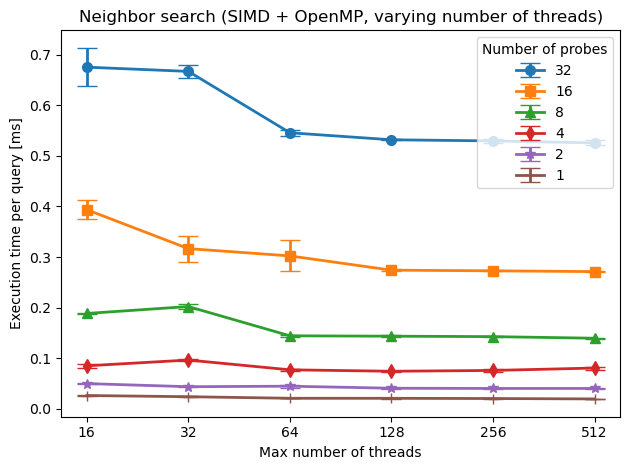

In [131]:
plot(df=varying_n_threads_n_probes, y_col='mean', yerr_col='std', title='preassign_query (SIMD + OpenMP, varying number of threads)', ylabel='Execution time per query [ms]', yformatter=s_to_ms_formatter, plot='max_n_threads')

**Throughput**
- It seems that the optimal maximum number of threads is actually `128` since the throughput is the highest for this number of threads.

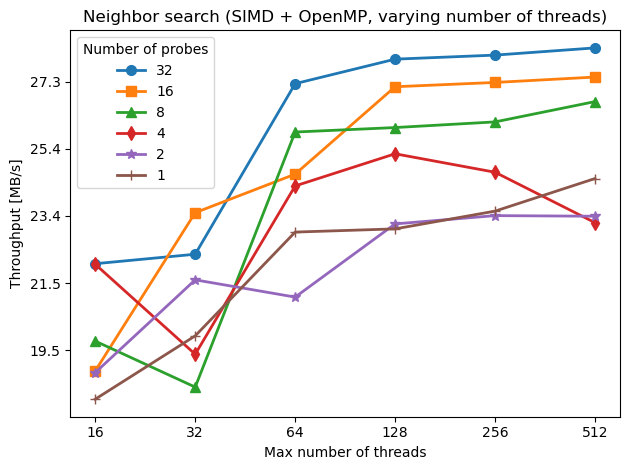

In [132]:
plot(df=varying_n_threads_n_probes, y_col='mb_per_s', title='preassign_query (SIMD + OpenMP, varying number of threads)', ylabel='Throughput [MB/s]', plot='max_n_threads', yformatter=mb_to_gb_formatter)

## `preassign_query()`

The benchmarks were executed with the following command the benchmark by running the following command:
```bash
export OMP_NUM_THREADS=64; ./out/testmain [StorageIndex][preassign_query][SIFT1M][benchmark] --benchmark-samples 3 -r xml >> preassign_query_simd_omp.xml
```

Reading from the xml file

In [133]:
results_simd_omp = parse_xml('preassign_query_simd_omp.xml')
centroids_simd_omp_df = results_to_df(results_simd_omp)
add_space_estimates(centroids_simd_omp_df)
add_centroids_search_throughput(centroids_simd_omp_df)
centroids_simd_omp_df['mean_speedup'] = get_speedup(old_df=centroids_df, new_df=centroids_simd_omp_df, column='mean', invert=True)
centroids_simd_omp_df

,n_lists,n_probe,mean,std,n_vectors_to_search,search_space_size_mb,centroids_total_size_mb,vectors_per_s,mb_per_s,mean_speedup
0,256,1,0.000004,5.377020e-08,3906.250000,1.9,0.1,65035528.2,31755.6,34.8
1,256,2,0.000004,3.194630e-07,7812.500000,3.8,0.1,61943326.7,30245.8,32.6
2,256,4,0.000004,6.304420e-08,15625.000000,7.6,0.1,68350510.0,33374.3,37.2
3,256,8,0.000004,1.439830e-07,31250.000000,15.3,0.1,65921784.8,32188.4,38.1
4,256,16,0.000004,1.070190e-07,62500.000000,30.5,0.1,58859911.1,28740.2,37.4
5,256,32,0.000005,1.615560e-07,125000.000000,61.0,0.1,50446431.2,24632.0,37.6
6,256,64,0.000006,8.034850e-08,250000.000000,122.1,0.1,46393873.1,22653.3,41.8
7,256,128,0.000008,1.383600e-07,500000.000000,244.1,0.1,32365528.2,15803.5,35.5
8,512,1,0.000007,2.170580e-07,1953.125000,1.0,0.2,72023205.0,35167.6,36.8
9,512,2,0.000007,2.401230e-07,3906.250000,1.9,0.2,70078619.5,34218.1,36.2


**Execution Time**

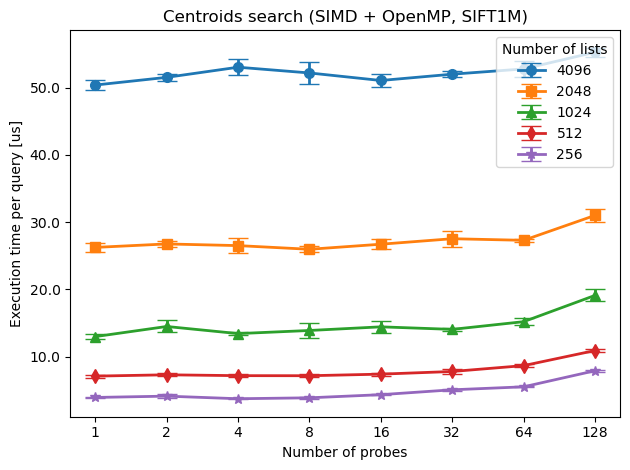

In [134]:
plot(df=centroids_simd_omp_df, y_col='mean', yerr_col='std', title='search_preassigned (SIMD + OpenMP, SIFT1M)', ylabel='Execution time per query [us]', yformatter=s_to_us_formatter)

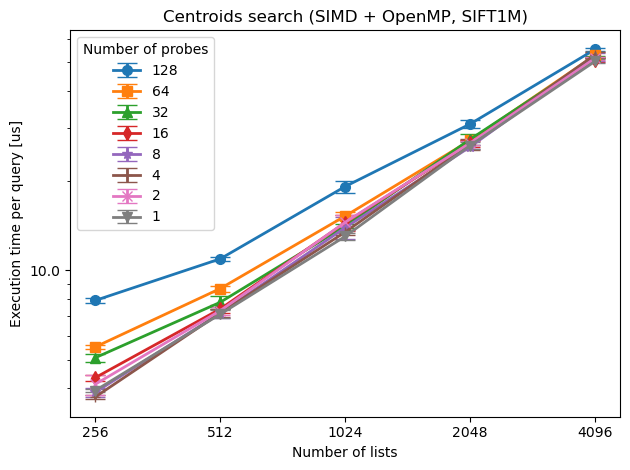

In [135]:
plot(df=centroids_simd_omp_df, y_col='mean', yerr_col='std', title='search_preassigned (SIMD + OpenMP, SIFT1M)', ylabel='Execution time per query [us]', yformatter=s_to_us_formatter, plot='n_lists', yaxis_log=True)

**Throughput**

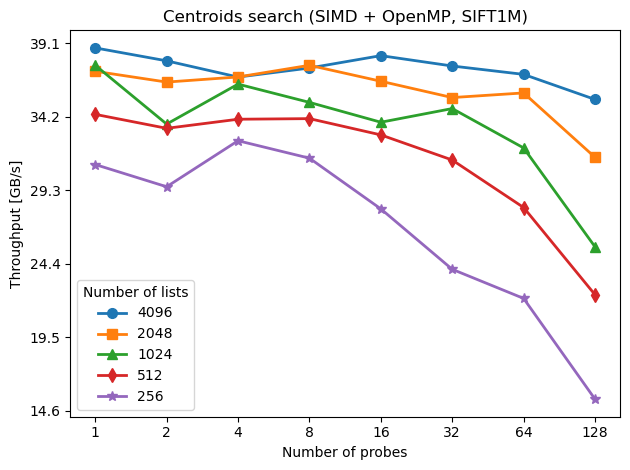

In [136]:
plot(df=centroids_simd_omp_df, y_col='mb_per_s', title='search_preassigned (SIMD + OpenMP, SIFT1M)', ylabel='Throughput [GB/s]', yformatter=mb_to_gb_formatter)

**Speedup**

Average SIMD + OpenMP speed-up for preassign_query(): 40.2x


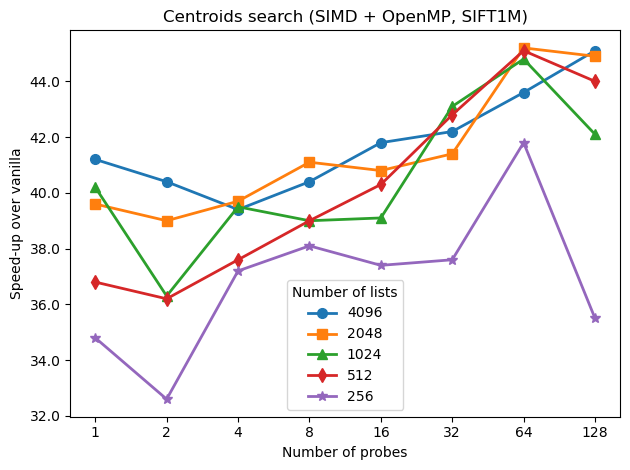

In [137]:
speedup = centroids_simd_omp_df['mean_speedup'].mean()
print(f'Average SIMD + OpenMP speed-up for preassign_query(): {speedup:.1f}x')
plot(df=centroids_simd_omp_df, y_col='mean_speedup', title='search_preassigned (SIMD + OpenMP, SIFT1M)', ylabel='Speed-up over vanilla', yformatter=speedup_formatter)

## `search_preassigned()`
The benchmarks were executed with the following command:
```bash
export OMP_NUM_THREADS=64; ./out/testmain [StorageIndex][search_preassigned][SIFT1M][benchmark] --benchmark-samples 3 -r xml >> search_preassigned_simd_omp.xml
```

Reading the measurements from the xml file

In [138]:
results_simd_omp = parse_xml('search_preassigned_simd_omp.xml')
search_simd_omp_df = results_to_df(results_simd_omp)
add_space_estimates(search_simd_omp_df)
add_search_throughput(search_simd_omp_df)
search_simd_omp_df['mean_speedup'] = get_speedup(old_df=search_df, new_df=search_simd_omp_df, column='mean', invert=True)
search_simd_omp_df

,n_lists,n_probe,mean,std,n_vectors_to_search,search_space_size_mb,centroids_total_size_mb,n_vectors_per_s,mb_per_s,mean_speedup
0,256,1,0.000089,5.021210e-06,3906.250000,1.9,0.1,44048181.5,21507.9,24.4
1,256,2,0.000144,5.188510e-07,7812.500000,3.8,0.1,54193257.5,26461.6,29.3
2,256,4,0.000225,7.528370e-07,15625.000000,7.6,0.1,69567811.4,33968.7,37.0
3,256,8,0.000442,3.569200e-07,31250.000000,15.3,0.1,70721677.9,34532.1,37.0
4,256,16,0.000951,1.676090e-05,62500.000000,30.5,0.1,65705025.4,32082.5,33.8
5,256,32,0.001930,7.768390e-05,125000.000000,61.0,0.1,64781944.0,31631.8,32.8
6,256,64,0.004433,2.109410e-04,250000.000000,122.1,0.1,56396617.1,27537.4,28.1
7,256,128,0.008397,1.396130e-04,500000.000000,244.1,0.1,59542664.7,29073.6,29.5
8,512,1,0.000048,7.215030e-08,1953.125000,1.0,0.2,40964910.4,20002.4,23.0
9,512,2,0.000072,1.516320e-06,3906.250000,1.9,0.2,54474016.3,26598.6,30.2


**Execution Time**

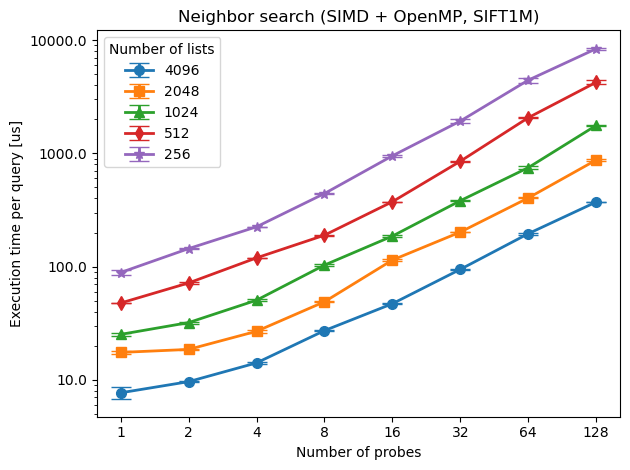

In [139]:
plot(df=search_simd_omp_df, y_col='mean', yerr_col='std', title='preassign_query (SIMD + OpenMP, SIFT1M)', ylabel='Execution time per query [us]', yformatter=s_to_us_formatter, yaxis_log=True)

**Throughput**

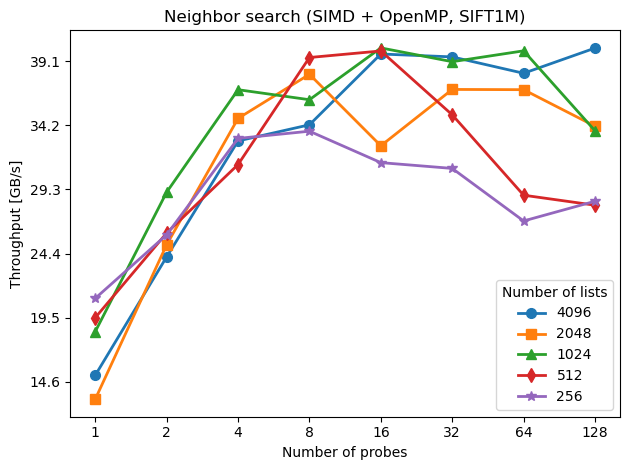

In [140]:
plot(df=search_simd_omp_df, y_col='mb_per_s', title='preassign_query (SIMD + OpenMP, SIFT1M)', ylabel='Throughput [GB/s]', yformatter=mb_to_gb_formatter)

**Speedup**

Average SIMD + OpenMP speed-up over vanilla search for search_preassigned(): 35.6x


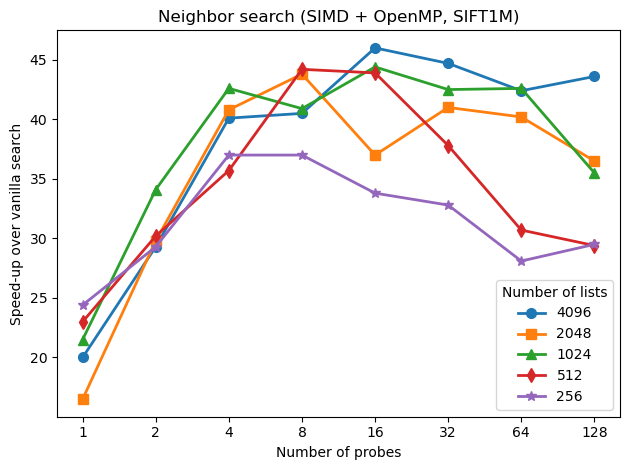

In [141]:
speedup = search_simd_omp_df['mean_speedup'].mean()
print(f'Average SIMD + OpenMP speed-up over vanilla search for search_preassigned(): {speedup:.1f}x')
plot(df=search_simd_omp_df, y_col='mean_speedup', title='preassign_query (SIMD + OpenMP, SIFT1M)', ylabel='Speed-up over vanilla search')

# SIMD, OpenMP (over queries and lists)

## `search_preassigned()`

The project was compiled to parallelization over both queries and lists using the following command:
```bash
make test PMODE=2
```


The benchmarks were executed by running the following command:
```bash
export OMP_NUM_THREADS=64; ./out/testmain [StorageIndex][search_preassigned][SIFT1M][benchmark] --benchmark-samples 3 -r xml >> search_preassigned_simd_omp_pmode2.xml
```

In [142]:
results_simd_omp_pmode2 = parse_xml('search_preassigned_simd_omp_pmode2.xml')
search_simd_omp_pmode2_df = results_to_df(results_simd_omp_pmode2)
add_space_estimates(search_simd_omp_pmode2_df)
add_search_throughput(search_simd_omp_pmode2_df)
search_simd_omp_pmode2_df['mean_speedup'] = get_speedup(old_df=search_simd_omp_df, new_df=search_simd_omp_pmode2_df, column='mean', invert=True)
search_simd_omp_pmode2_df

,n_lists,n_probe,mean,std,n_vectors_to_search,search_space_size_mb,centroids_total_size_mb,n_vectors_per_s,mb_per_s,mean_speedup
0,256,1,0.000088,1.028950e-06,3906.250000,1.9,0.1,44275095.5,21618.7,1.0
1,256,2,0.000171,2.364040e-06,7812.500000,3.8,0.1,45655896.3,22292.9,0.8
2,256,4,0.000338,4.320410e-06,15625.000000,7.6,0.1,46167028.6,22542.5,0.7
3,256,8,0.000543,3.847380e-06,31250.000000,15.3,0.1,57557216.5,28104.1,0.8
4,256,16,0.001067,1.057010e-05,62500.000000,30.5,0.1,58556786.0,28592.2,0.9
5,256,32,0.002289,5.186840e-06,125000.000000,61.0,0.1,54600889.3,26660.6,0.8
6,256,64,0.004104,9.311060e-05,250000.000000,122.1,0.1,60917812.1,29745.0,1.1
7,256,128,0.008209,2.575860e-04,500000.000000,244.1,0.1,60912320.4,29742.3,1.0
8,512,1,0.000052,9.901940e-07,1953.125000,1.0,0.2,37753364.3,18434.3,0.9
9,512,2,0.000093,1.666660e-06,3906.250000,1.9,0.2,41873690.2,20446.1,0.8


**Execution Time**

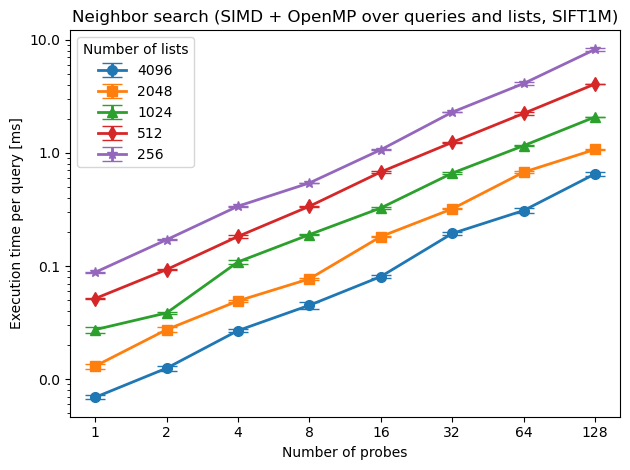

In [143]:
plot(df=search_simd_omp_pmode2_df, y_col='mean', yerr_col='std', title='preassign_query (SIMD + OpenMP over queries and lists, SIFT1M)', ylabel='Execution time per query [ms]', yformatter=s_to_ms_formatter, yaxis_log=True)

**Throughput**

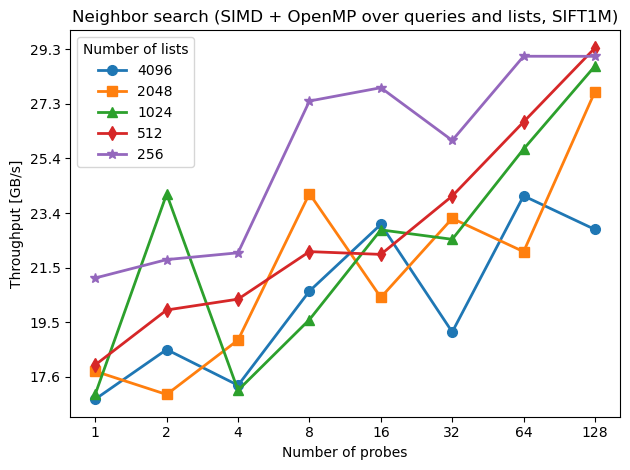

In [144]:
plot(df=search_simd_omp_pmode2_df, y_col='mb_per_s', title='preassign_query (SIMD + OpenMP over queries and lists, SIFT1M)', ylabel='Throughput [GB/s]', yformatter=mb_to_gb_formatter)

**Speedup**

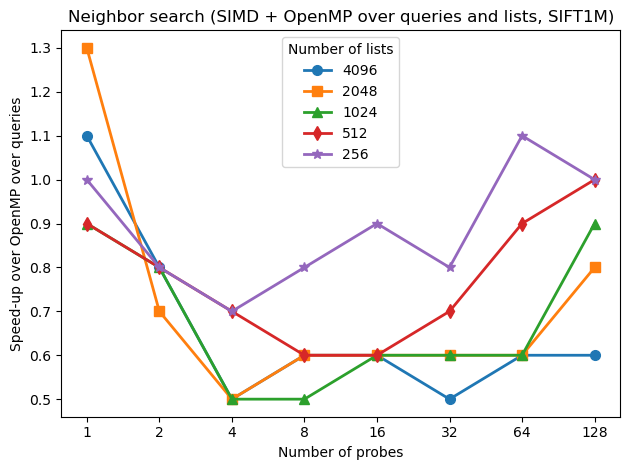

In [145]:
plot(df=search_simd_omp_pmode2_df, y_col='mean_speedup', title='preassign_query (SIMD + OpenMP over queries and lists, SIFT1M)', ylabel='Speed-up over OpenMP over queries')

### Varying `n_probes` and `n_results`
- Maximum number of threads: `64`

In [146]:
search_simd_omp_pmode2_varying_nresults_df = results_to_df(parse_xml('search_preassigned_simd_omp_pmode2_varying_nresults.xml'))
add_space_estimates(search_simd_omp_pmode2_varying_nresults_df)
add_search_throughput(search_simd_omp_pmode2_varying_nresults_df)
search_simd_omp_pmode2_varying_nresults_df

,n_lists,n_probe,n_results,mean,std,n_vectors_to_search,search_space_size_mb,centroids_total_size_mb,n_vectors_per_s,mb_per_s
0,1024,1,1,0.000023,2.625800e-07,976.5625,0.5,0.5,41945317.8,20481.1
1,1024,2,1,0.000048,3.383480e-07,1953.1250,1.0,0.5,40624766.0,19836.3
2,1024,4,1,0.000099,2.930980e-06,3906.2500,1.9,0.5,39414670.1,19245.4
3,1024,8,1,0.000163,2.834380e-05,7812.5000,3.8,0.5,48059178.1,23466.4
4,1024,16,1,0.000285,9.822030e-07,15625.0000,7.6,0.5,54839955.1,26777.3
...,...,...,...,...,...,...,...,...,...,...
59,1024,8,128,0.000918,8.540450e-06,7812.5000,3.8,0.5,8510098.3,4155.3
60,1024,16,128,0.001620,1.523610e-05,15625.0000,7.6,0.5,9645895.3,4709.9
61,1024,32,128,0.003049,1.322980e-04,31250.0000,15.3,0.5,10248892.3,5004.3
62,1024,64,128,0.005697,8.091570e-05,62500.0000,30.5,0.5,10971148.5,5357.0


**Execution Time**

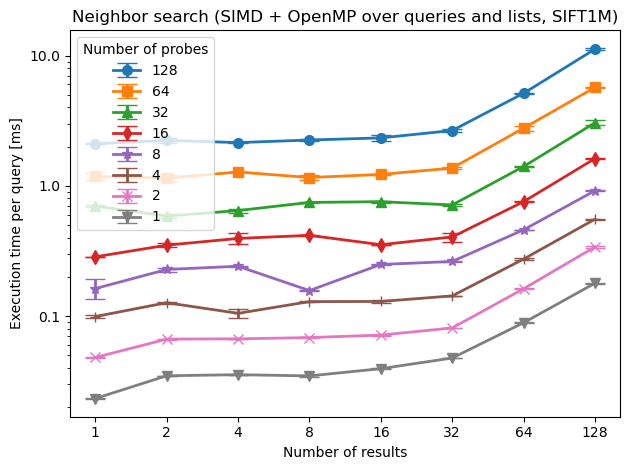

In [147]:
plot(df=search_simd_omp_pmode2_varying_nresults_df, y_col='mean', yerr_col='std', title='preassign_query (SIMD + OpenMP over queries and lists, SIFT1M)', ylabel='Execution time per query [ms]', yformatter=s_to_ms_formatter, plot='n_results', yaxis_log=True)

**Throughput**
- critical region

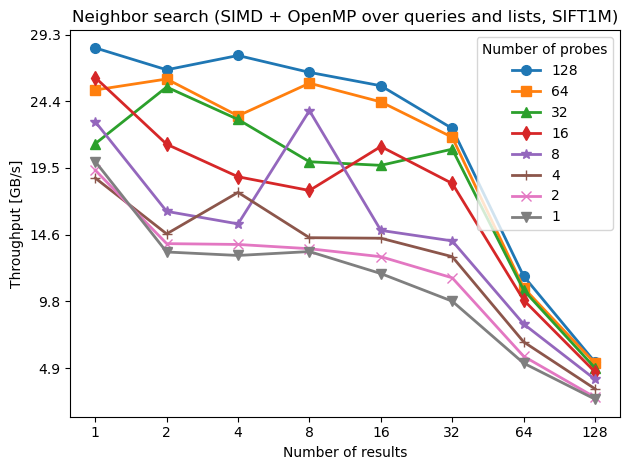

In [148]:
plot(df=search_simd_omp_pmode2_varying_nresults_df, y_col='mb_per_s', title='preassign_query (SIMD + OpenMP over queries and lists, SIFT1M)', ylabel='Throughput [GB/s]', yformatter=mb_to_gb_formatter, plot='n_results')

**Recall**


In [149]:
search_recall_simd_omp_pmode2_df = results_to_df(parse_xml_recall('search_preassigned_recall_simd_omp_pmode2.xml'))
# add_space_estimates(search_recall_simd_omp_pmode2_df)
# add_search_throughput(search_recall_simd_omp_pmode2_df)
search_recall_simd_omp_pmode2_df

OSError: Error reading file 'search_preassigned_recall_simd_omp_pmode2.xml': failed to load external entity "search_preassigned_recall_simd_omp_pmode2.xml"

**old Recall measurements**

In [ ]:
n_lists_arr = []
n_probe_arr = []
recall_at_1_arr = []
with open('recall/measurements.log', 'r') as f:
    for line in f:
        if line.startswith('Inserted'):
          continue
        value = line.strip().split(' ')[1]
        if line.startswith('n_lists'):
            n_lists_arr.append(int(value))
        elif line.startswith('n_probe'):
            n_probe_arr.append(int(value))
        elif line.startswith('Recall@1'):
            recall_at_1_arr.append(float(value))
measurements = list(zip(n_lists_arr, n_probe_arr, recall_at_1_arr))
def get_plot_data(n_lists):
    recall_at_1 = [x[2] for x in measurements if x[0] == n_lists]
    n_probe = [x[1] for x in measurements if x[0] == n_lists]
    return n_probe, recall_at_1

In [ ]:
fig, ax = plt.subplots(tight_layout=True)

ax.set_prop_cycle(marker_cycler)

bars = []
for n_lists in sorted(set(n_lists_arr)):
    bars.append(ax.plot(
        get_plot_data(n_lists)[0],
        get_plot_data(n_lists)[1],  
        label=f"{n_lists} lists"
    ))
ax.set_title('Index: Recall@1 (SIFT1M)')

ax.set_xlabel("Number of probes")
ax.set_ylabel("Recall@1")

ax.set_xscale("log")
ax.xaxis.set_major_locator(ticker.LogLocator(base=2))
ax.xaxis.set_minor_locator(ticker.NullLocator())
ax.xaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=False))

ax.legend()
plt.savefig('recall/index-recall-at-1.jpg', dpi=300)
plt.show()
